# Notebook 1: Data Preparation and Exploratory Data Analysis (EDA)
**Goal:** Load the raw IMF data, clean/reshape it, calculate year-over-year growth rates, and perform an initial visual analysis.

**Output:** A cleaned dataset `imf_data_clean.pkl` for subsequent analysis.

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## 1. Load and Reshape Data

In [7]:
file_path = "./data.csv" # Ensure data.csv is in the same folder
df = pd.read_csv(file_path, sep=";")

# Define variables for melting
id_vars = [
    'WEO Country Code', 'ISO', 'WEO Subject Code', 'Country',
    'Subject Descriptor', 'Subject Notes', 'Units', 'Scale',
    'Country/Series-specific Notes', 'Estimates Start After'
]

# Reshape from Wide to Long format
df_long = pd.melt(
    df,
    id_vars=id_vars,
    var_name='Year',
    value_name='Value'
)

# Convert types
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
df_long.dropna(subset=['Value'], inplace=True)

print("Data loaded and reshaped. Shape:", df_long.shape)

Data loaded and reshaped. Shape: (287497, 12)


## 2. Filter and Feature Engineering
We focus on 4 major economies: Switzerland, Germany, USA, China.

Metrics: GDP (Constant Prices), Inflation (CPI), Unemployment Rate.

In [8]:
countries_to_analyze = ['Switzerland', 'Germany', 'United States', 'China']
subjects_to_analyze = [
    'Gross domestic product, constant prices',
    'Inflation, average consumer prices',
    'Unemployment rate'
]

df_filtered = df_long[
    (df_long['Country'].isin(countries_to_analyze)) &
    (df_long['Subject Descriptor'].isin(subjects_to_analyze))
]

# --- Calculate Inflation Rate (YoY) from Index ---
df_inflation_index = df_filtered[
    (df_filtered['Subject Descriptor'] == 'Inflation, average consumer prices') &
    (df_filtered['Units'] == 'Index')
].copy()

df_inflation_index = df_inflation_index.sort_values(by=['Country', 'Year'])
df_inflation_index['Value'] = df_inflation_index.groupby('Country')['Value'].pct_change() * 100
df_inflation_index['Subject Descriptor'] = 'Inflation Rate (YoY)'
df_inflation_index['Units'] = 'Percent change (YoY)'
df_inflation_index = df_inflation_index.dropna(subset=['Value'])

# --- Prepare GDP Growth Data ---
df_gdp_growth = df_filtered[
    (df_filtered['Subject Descriptor'] == 'Gross domestic product, constant prices') &
    (df_filtered['Units'] == 'Percent change')
].copy()
df_gdp_growth['Subject Descriptor'] = 'GDP Growth Rate (YoY)'

# --- Prepare Unemployment Data ---
df_unemployment = df_filtered[
    (df_filtered['Subject Descriptor'] == 'Unemployment rate')
].copy()

# --- Merge into Final DataFrame ---
df_analysis = pd.concat([
    df_gdp_growth,
    df_inflation_index,
    df_unemployment
], ignore_index=True)

print("Final Analysis DataFrame Shape:", df_analysis.shape)
print(df_analysis['Subject Descriptor'].value_counts())

Final Analysis DataFrame Shape: (548, 12)
Subject Descriptor
GDP Growth Rate (YoY)    184
Unemployment rate        184
Inflation Rate (YoY)     180
Name: count, dtype: int64


## 3. Exploratory Data Analysis (EDA)
Visualizing distributions to identify outliers and skewness (justifying robust methods later).

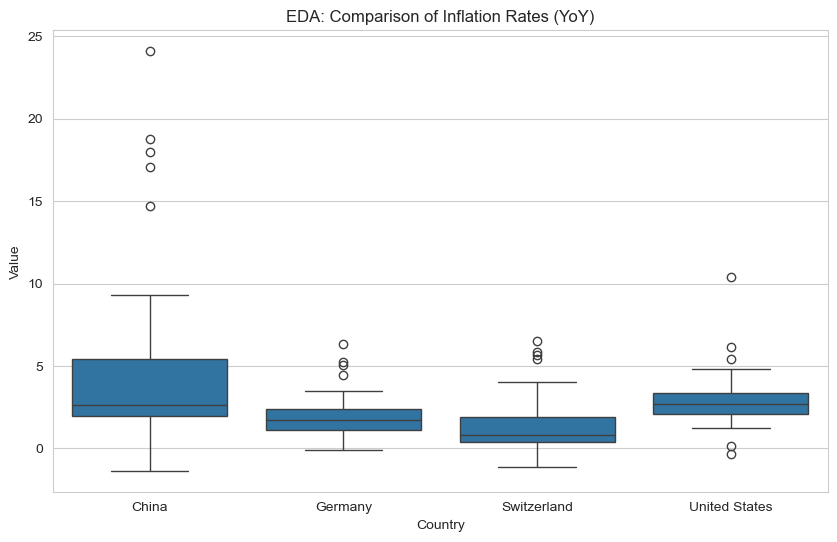

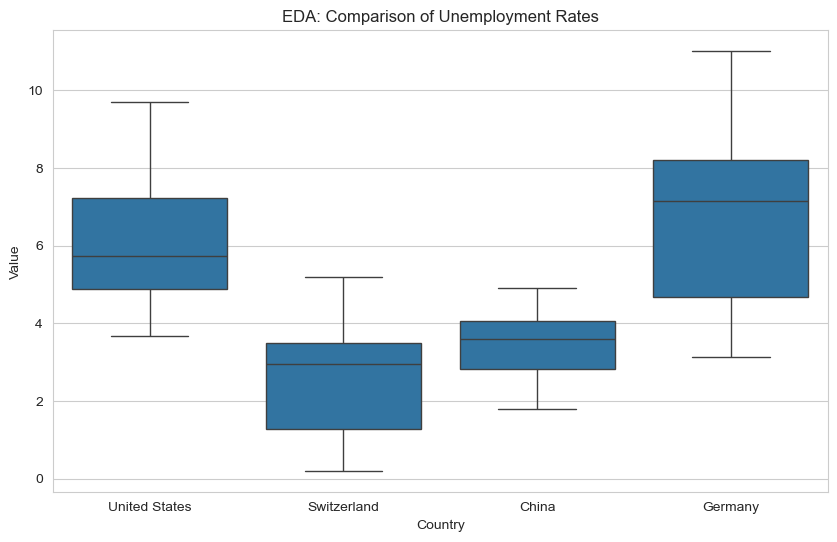

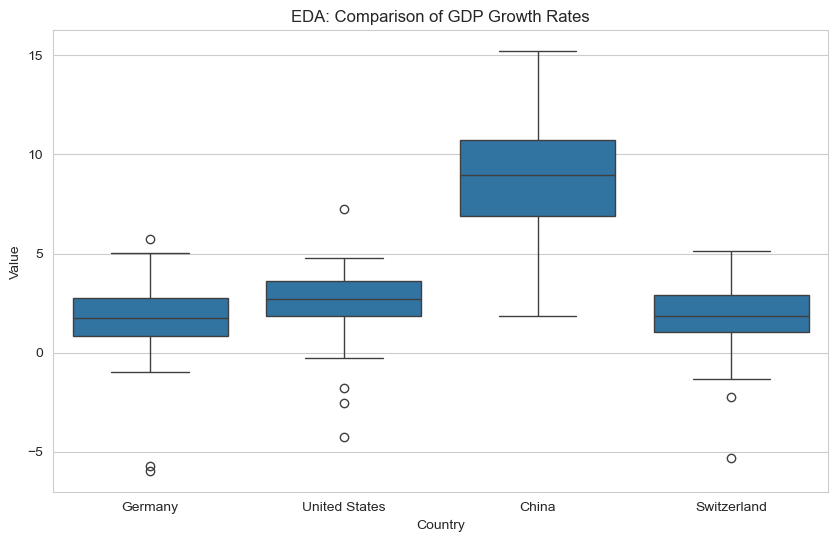

In [9]:
# Inflation Comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x='Country', y='Value', data=df_analysis[df_analysis['Subject Descriptor'] == 'Inflation Rate (YoY)'])
plt.title('EDA: Comparison of Inflation Rates (YoY)')
plt.show()

# Unemployment Comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x='Country', y='Value', data=df_analysis[df_analysis['Subject Descriptor'] == 'Unemployment rate'])
plt.title('EDA: Comparison of Unemployment Rates')
plt.show()

# GDP Growth Comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x='Country', y='Value', data=df_analysis[df_analysis['Subject Descriptor'] == 'GDP Growth Rate (YoY)'])
plt.title('EDA: Comparison of GDP Growth Rates')
plt.show()

### EDA Conclusion
* **China** shows significantly higher growth and larger variance (outliers) in GDP.
* **Switzerland** appears very stable (small IQR) in Inflation.
* **Data Distribution:** Due to visible outliers and skewness, we will use **robust statistical tests** (Spearman, Kruskal-Wallis) in the following notebooks.

## 4. Save Data for Next Notebooks
Saving as Pickle to preserve data types.

In [10]:
df_analysis.to_pickle("imf_data_clean.pkl")
print("Data saved successfully as 'imf_data_clean.pkl'")

Data saved successfully as 'imf_data_clean.pkl'
